# User reviews for fashion items

In this section, we do a general exploration of the dataset, cleaning, and preparation for further analysis and ML pipeline. The early detection of the relationship between the variables is crucial to building an unbiased analysis, avoiding the assumption of independence in correlated phenomenons. Additionally, the treatment of missing data, detection of outliers, and anomalies running statistical tests give us meaningful information for the pertinent interpretation of predictive modeling results, drawbacks, replication of the results, and scopes of the project.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import scipy as scp
import matplotlib.pyplot as plt

import statsmodels.api as sm
import scipy.stats as stats
import pylab

/Users/daniela/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:1003: UserWarning: Duplicate key in file "/Users/daniela/.matplotlib/matplotlibrc", line #2
  (fname, cnt))
/Users/daniela/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:1003: UserWarning: Duplicate key in file "/Users/daniela/.matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
pd.set_option('display.max_colwidth', -1)

In [3]:
df_review = pd.read_csv('dataset/raw/Womens_Clothing_E-Commerce_Reviews.csv', index_col=0)

In [4]:
df_review.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23486 entries, 0 to 23485
Data columns (total 10 columns):
Clothing ID                23486 non-null int64
Age                        23486 non-null int64
Title                      19676 non-null object
Review Text                22641 non-null object
Rating                     23486 non-null int64
Recommended IND            23486 non-null int64
Positive Feedback Count    23486 non-null int64
Division Name              23472 non-null object
Department Name            23472 non-null object
Class Name                 23472 non-null object
dtypes: int64(5), object(5)
memory usage: 2.0+ MB


In [5]:
df_review.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,"Love this dress! it's sooo pretty. i happened to find it in a store, and i'm glad i did bc i never would have ordered it online bc it's petite. i bought a petite and am 5'8"". i love the length on me- hits just a little below the knee. would definitely be a true midi on someone who is truly petite.",5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,"I had such high hopes for this dress and really wanted it to work for me. i initially ordered the petite small (my usual size) but i found this to be outrageously small. so small in fact that i could not zip it up! i reordered it in petite medium, which was just ok. overall, the top half was comfortable and fit nicely, but the bottom half had a very tight under layer and several somewhat cheap (net) over layers. imo, a major design flaw was the net over layer sewn directly into the zipper - it c",3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabulous! every time i wear it, i get nothing but great compliments!",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to the adjustable front tie. it is the perfect length to wear with leggings and it is sleeveless so it pairs well with any cardigan. love this shirt!!!,5,1,6,General,Tops,Blouses


## Customer Profile

### 1. Age Distribution

Age distribution gives us information about the target consumers of the clothing store. Later, we are going to decide how to cluster them to analyze the trends by group. Stylish, polarity, subjectivity of writting patterns or other interesting phenomenons could be related to the age group.

In [6]:
mean_age = df_review.Age.mean()
std_age = df_review.Age.std()
p25 = np.percentile(df_review.Age, 25)
p75 = np.percentile(df_review.Age, 75)

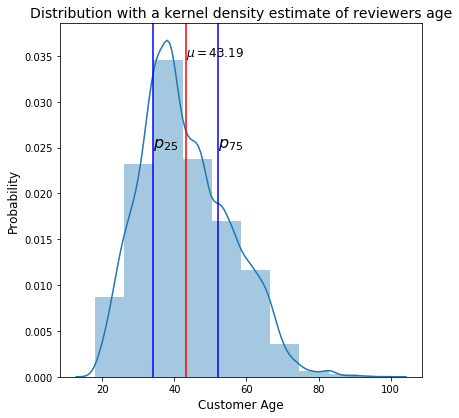

In [7]:
_ = plt.figure(figsize=(6.5, 6.5))
_ = sns.distplot(df_review.Age, bins=10)
_ = plt.axvline(mean_age, color='r')
_ = plt.axvline(p25, color='b')
_ = plt.axvline(p75, color='b')
_ = plt.text(mean_age, 0.035, r'$\mu = 43.19$', fontsize=12)
_ = plt.text(p25, 0.025, r'$p_{25}$', fontsize=16)
_ = plt.text(p75, 0.025, r'$p_{75}$', fontsize=16)
_ = plt.xlabel('Customer Age', size=12)
_ = plt.ylabel('Probability', size=12)
_ = plt.title('Distribution with a kernel density estimate of reviewers age', size=14)

Is this variable normally distributed? The problem with histograms is that the appearance of the distribution depends on the number of bins selected. We'll apply the **normality test Shapiro Wilk**, complementing with Boxplot and Q-Q plots (as we know, when the sample size get large, small deviations from the perfect normality will lead to a significant results and the test rejects the null hypothesis).

Shapiro Wilk is the most powerful test, but it could fail for sample size upper than 5000 datapoints. Therefore, 10% of population (2000 datapoints) are selected randomly and used in the test. 

In [8]:
n = 2000
X = np.random.choice(df_review.Age, n)
statistic, p_value = scp.stats.shapiro(X)
print('p_value: {}'.format(p_value))
if p_value < 0.05:
    print('We reject the null hypothesis. There is evidence that the data is not from a normally distributed population')
else:
    print('We fail to reject the null hypothesis.')

p_value: 1.5057911498492835e-17
We reject the null hypothesis. There is evidence that the data is not from a normally distributed population


Let's try another test. Any distribution could be compared with a theorical distribution through the **Kolmogorov Smirnov test**. In this case, we compare the distribution of the whole population with a normal distribution with parameters mu and sigma calculated from the empirical distribution. If p < .05 we can reject the null, and conclude our sample distribution is not identical to a normal distribution.

In [9]:
# Perform test KS test against a normal distribution with mean = 43.198 
# and sd = 12.27
statistic, p_value = scp.stats.kstest(df_review.Age, 'norm', args=(mean_age, std_age))
print('p_value: {}'.format(p_value))
if p_value < 0.05:
    print('We reject the null hypothesis. The distribution is not identical to a normal distribution.')
else:
    print('We fail to reject the null hypothesis.')

p_value: 3.6315115645513653e-153
We reject the null hypothesis. The distribution is not identical to a normal distribution.


Finally, we display a **Quantile-Quantile plot**. This method considers a normally distributed set and the one we are analyzing. If the two distributions being compared are from a common distribution, the points in the plot will approximately lie on a line.

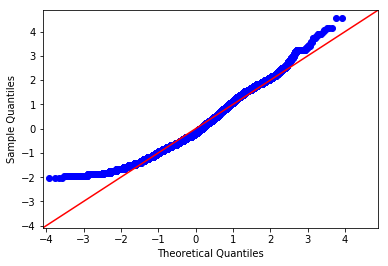

In [10]:
sm.qqplot(df_review.Age, stats.t, fit=True, line="45")
pylab.show()

And, as we can expect, that's not the case.

## Rating Distribution

In [11]:
ratings = df_review.groupby(['Rating']).count()['Clothing ID'].reset_index()
ratings['percent'] = 100*ratings['Clothing ID']/ratings['Clothing ID'].sum()

In [12]:
ratings

,Rating,Clothing ID,percent
0,1,842,3.585115
1,2,1565,6.663544
2,3,2871,12.224304
3,4,5077,21.617134
4,5,13131,55.909904


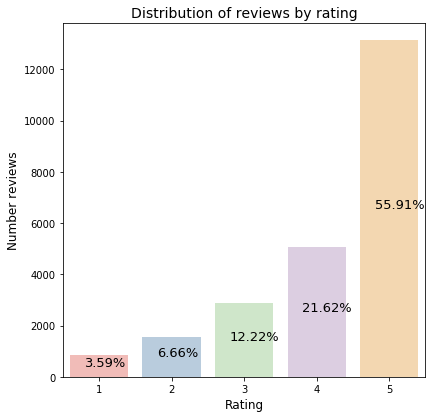

In [13]:
_ = plt.figure(figsize=(6.5, 6.5))
_ = sns.barplot(x=ratings.Rating, y = ratings['Clothing ID'], palette='Pastel1')
_ = plt.xlabel('Rating', size=12)
_ = plt.ylabel('Number reviews', size=12)
_ = plt.title('Distribution of reviews by rating', size=14)

for i in range(len(ratings)):
    _ = plt.text(ratings.Rating[i]-1.2, 
                 ratings['Clothing ID'][i]/2, 
                 str(round(ratings.percent[i], 2))+'%', 
                 fontsize=13)

In [14]:
df_sampleRating = df_review.groupby('Rating').apply(lambda x: x.sample(n=800)).reset_index(drop = True)

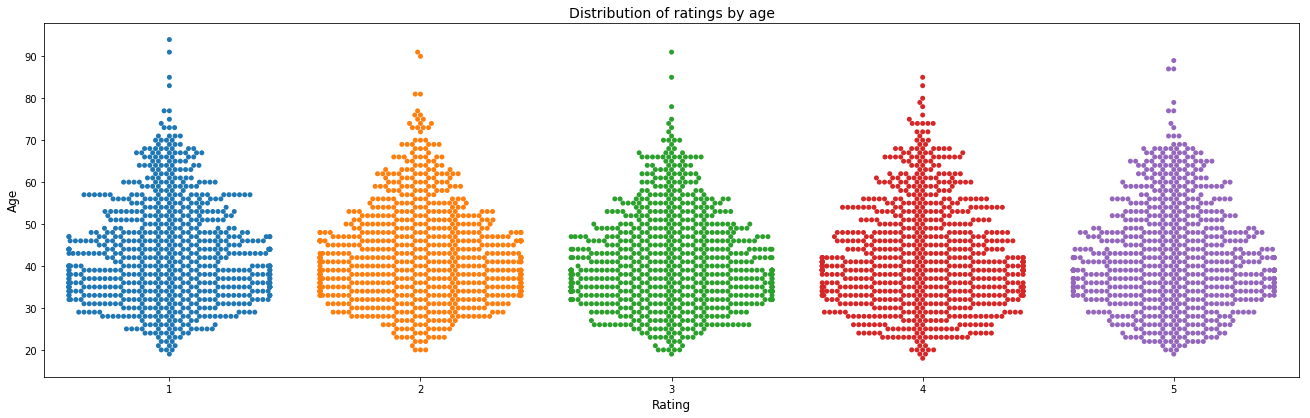

In [15]:
_ = plt.figure(figsize=(22.5, 6.5))
_ = sns.swarmplot(y="Age", x="Rating", data=df_sampleRating)
_ = plt.xlabel('Rating', size=12)
_ = plt.ylabel('Age', size=12)
_ = plt.title('Distribution of ratings by age', size=14)

In [16]:
df_sample = df_review.sample(frac=0.05, random_state=1)

In [17]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1174 entries, 8061 to 4906
Data columns (total 10 columns):
Clothing ID                1174 non-null int64
Age                        1174 non-null int64
Title                      982 non-null object
Review Text                1135 non-null object
Rating                     1174 non-null int64
Recommended IND            1174 non-null int64
Positive Feedback Count    1174 non-null int64
Division Name              1174 non-null object
Department Name            1174 non-null object
Class Name                 1174 non-null object
dtypes: int64(5), object(5)
memory usage: 100.9+ KB


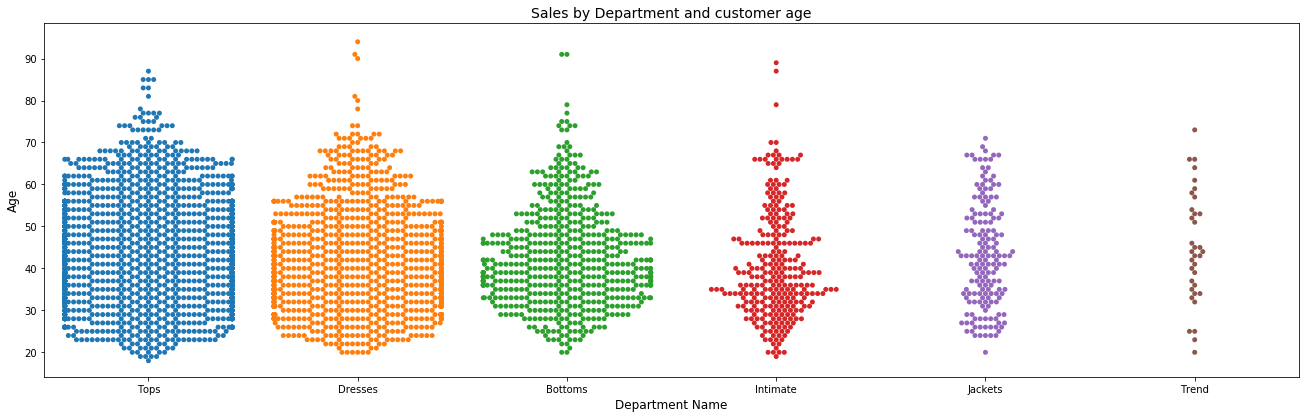

In [18]:
_ = plt.figure(figsize=(22.5, 6.5))
_ = sns.swarmplot(y="Age", x="Department Name", data=df_sampleRating)
_ = plt.xlabel('Department Name', size=12)
_ = plt.ylabel('Age', size=12)
_ = plt.title('Sales by Department and customer age', size=14)

### Analysis of Rating by Department

- Count the number of every rating by department to compare the evaluation of the public (relative terms)

To compare ratings by department, firstly we calculate the relative percentage of ratings by department. 

In [19]:
d = df_review.groupby(['Department Name', 'Rating']).agg({'Department Name': 'count'})
d['percentage reviews'] = d/d.groupby(level=0).sum()
d.index.rename(['Department', 'Rating'], inplace=True)
d.rename({'Department Name': 'number reviews'}, axis=1, inplace=True)
d

number reviews  percentage reviews
Department Rating                                    
Bottoms    1       115             0.030271          
           2       205             0.053962          
           3       421             0.110819          
           4       785             0.206633          
           5       2273            0.598315          
Dresses    1       228             0.036082          
           2       461             0.072955          
           3       838             0.132616          
           4       1395            0.220763          
           5       3397            0.537585          
Intimate   1       63              0.036311          
           2       90              0.051873          
           3       178             0.102594          
           4       371             0.213833          
           5       1033            0.595389          
Jackets    1       49              0.047481          
           2       60              0.058140          
           3       91              0.088178          
           4       201             0.194767          
           5       631             0.611434          
Tops       1       376             0.035919          
           2       738             0.070501          
           3       1324            0.126481          
           4       2299            0.219622          
           5       5731            0.547478          
Trend      1       11              0.092437          
           2       11              0.092437          
           3       19              0.159664          
           4       26              0.218487          
           5       52              0.436975

In [20]:
d.reset_index(inplace=True)

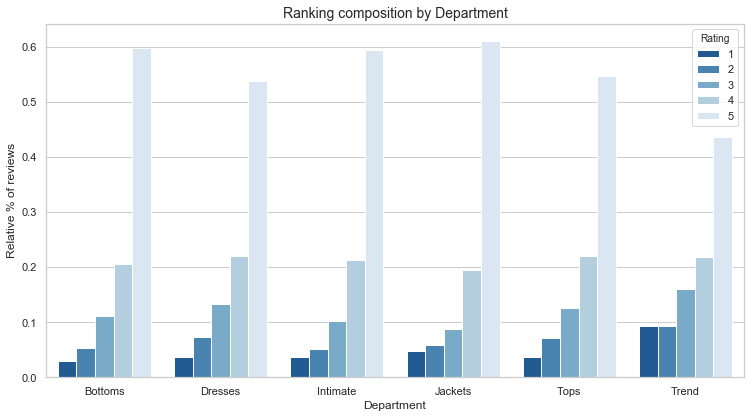

In [21]:
_ = sns.set(style='whitegrid') #{darkgrid, whitegrid, dark, white, ticks}
_ = plt.figure(figsize=(12.5, 6.5))
_ = sns.barplot(x='Department', y='percentage reviews', hue='Rating', data=d, palette='Blues_r')
_ = plt.xlabel('Department', size=12)
_ = plt.ylabel('Relative % of reviews', size=12)
_ = plt.title('Ranking composition by Department', size=14)

Trend, which is the department with less number of reviews in absolute terms, it is also the section with less 5 scores and more 1, 2 and 3 scores in reviews in relative terms. We can see this more clearly in the next display,

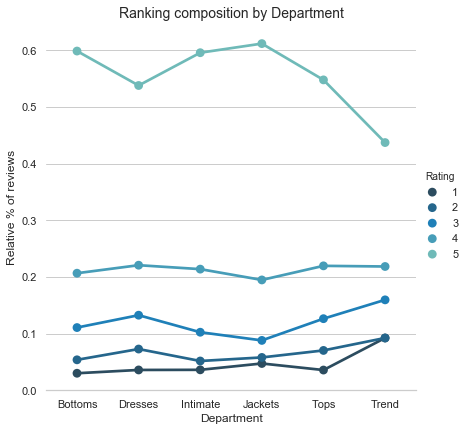

In [22]:
g = sns.catplot(x='Department', y='percentage reviews', hue='Rating',
                capsize=.2, palette="YlGnBu_d", height=6, aspect=1,
                kind="point", data=d)
_ = plt.xlabel('Department', size=12)
_ = plt.ylabel('Relative % of reviews', size=12)
_ = plt.title('Ranking composition by Department', size=14)

g.despine(left=True)

The percentage of 4 scores is similar between departments. 5 scores by ranking varies between 43% and 61% between Departments, but **is only less than 50% in the Department Trend**. 1 score represents the 3% or 4% of the scores by Department, but **is upper 9% exclusively in Department Trend**.

In [23]:
df_review.groupby('Department Name').count()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Class Name
Department Name,,,,,,,,,
Bottoms,3799,3799,3184,3662,3799,3799,3799,3799,3799
Dresses,6319,6319,5372,6145,6319,6319,6319,6319,6319
Intimate,1735,1735,1408,1653,1735,1735,1735,1735,1735
Jackets,1032,1032,879,1002,1032,1032,1032,1032,1032
Tops,10468,10468,8713,10048,10468,10468,10468,10468,10468
Trend,119,119,107,118,119,119,119,119,119


In [24]:
department = df_review.groupby(['Department Name']).count()['Clothing ID'].reset_index()
department['percent'] = 100*department['Clothing ID']/department['Clothing ID'].sum()

In [25]:
department

,Department Name,Clothing ID,percent
0,Bottoms,3799,16.185242
1,Dresses,6319,26.921438
2,Intimate,1735,7.391786
3,Jackets,1032,4.396728
4,Tops,10468,44.597819
5,Trend,119,0.506987


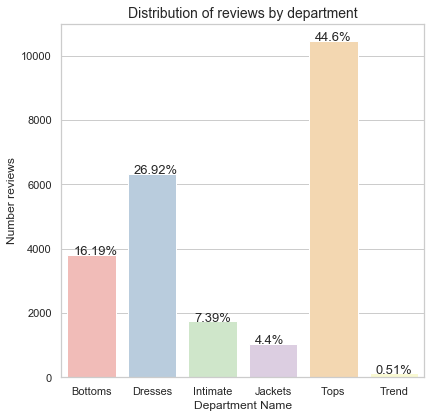

In [26]:
_ = plt.figure(figsize=(6.5, 6.5))
_ = sns.barplot(x=department['Department Name'], y = department['Clothing ID'], palette='Pastel1')
_ = plt.xlabel('Department Name', size=12)
_ = plt.ylabel('Number reviews', size=12)
_ = plt.title('Distribution of reviews by department', size=14)

for i in range(len(department)):
    _ = plt.text(i-0.3, 
                 department['Clothing ID'][i], 
                 str(round(department.percent[i], 2))+'%', 
                 fontsize=13)

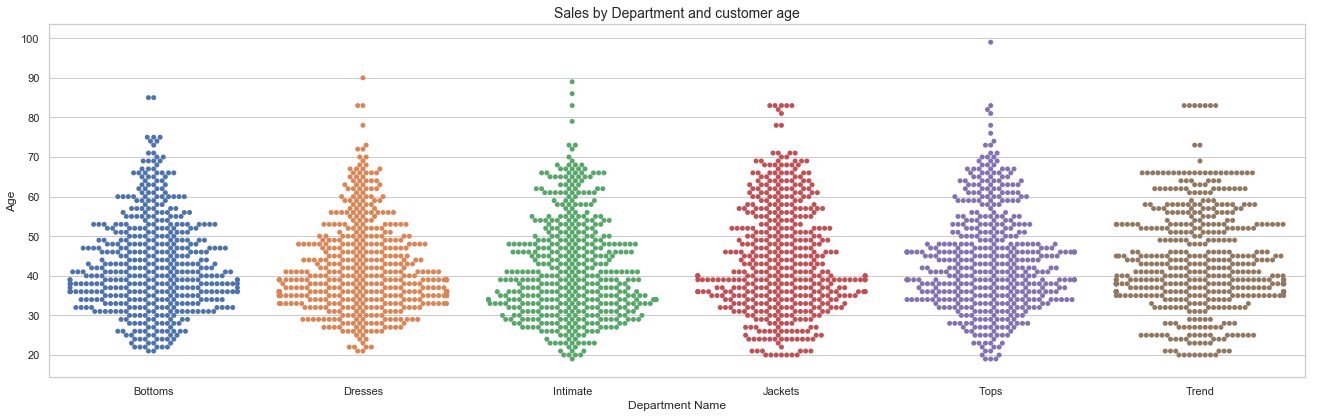

In [27]:
df_sampleDepto = df_review.groupby('Department Name').apply(lambda x: x.sample(n=500, replace=True)).reset_index(drop = True)

_ = plt.figure(figsize=(22.5, 6.5))
_ = sns.swarmplot(y="Age", x="Department Name", data=df_sampleDepto)
_ = plt.ylabel('Age', size=12)
_ = plt.xlabel('Department Name', size=12)
_ = plt.title('Sales by Department and customer age', size=14)

In [28]:
df_review.groupby(['Department Name', 'Division Name']).count()

Clothing ID   Age  Title  Review Text  Rating  \
Department Name Division Name                                                   
Bottoms         General         2542         2542  2121   2447         2542     
                General Petite  1257         1257  1063   1215         1257     
Dresses         General         3730         3730  3166   3619         3730     
                General Petite  2589         2589  2206   2526         2589     
Intimate        General Petite  233          233   188    227          233      
                Initmates       1502         1502  1220   1426         1502     
Jackets         General         645          645   547    624          645      
                General Petite  387          387   332    378          387      
Tops            General         6837         6837  5743   6580         6837     
                General Petite  3631         3631  2970   3468         3631     
Trend           General         96           96    88     95           96       
                General Petite  23           23    19     23           23       

                                Recommended IND  Positive Feedback Count  \
Department Name Division Name                                              
Bottoms         General         2542             2542                      
                General Petite  1257             1257                      
Dresses         General         3730             3730                      
                General Petite  2589             2589                      
Intimate        General Petite  233              233                       
                Initmates       1502             1502                      
Jackets         General         645              645                       
                General Petite  387              387                       
Tops            General         6837             6837                      
                General Petite  3631             3631                      
Trend           General         96               96                        
                General Petite  23               23                        

                                Class Name  
Department Name Division Name               
Bottoms         General         2542        
                General Petite  1257        
Dresses         General         3730        
                General Petite  2589        
Intimate        General Petite  233         
                Initmates       1502        
Jackets         General         645         
                General Petite  387         
Tops            General         6837        
                General Petite  3631        
Trend           General         96          
                General Petite  23

## Positive feedback and Recommended IND

The following plot displays the positive feedback counts by customer age and department. Dresses concentrates the highest positive feedbacks. Jackets, Intimate and Trends belong to the categories with less positive counts.

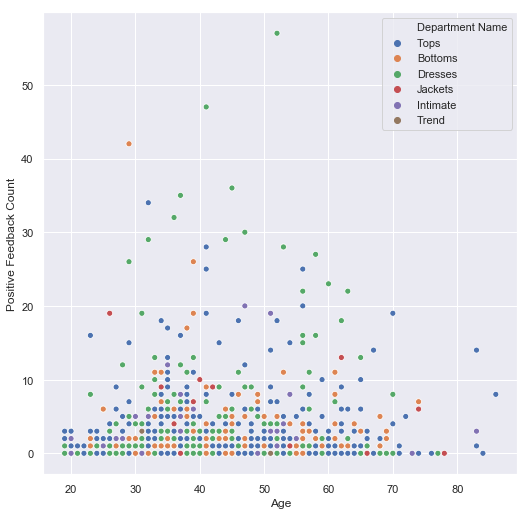

In [29]:
cmap = sns.cubehelix_palette(rot=-.2, as_cmap=True)

_ = plt.figure(figsize=(8.5, 8.5))
_ = sns.set(style="darkgrid")
_ = sns.scatterplot(y='Positive Feedback Count', x='Age', hue='Department Name', data=df_sample)

The column `Recommended IND` gives us information related to the `Review Text` column. As we can see below, some customers put high ratings but still no recommending the products. The reason behind the no recommendation is on the review itself.

In [30]:
df_noRecommended = df_review[(df_review['Recommended IND'] == 0) & (df_review['Rating'] == 5)]
df_noRecommended.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
1333,836,25,"Cute shirt, but not for me",The blue lace with the white top underneath is very pretty. unfortunately i did not like how billowy it was below the bra line.,5,0,0,General,Tops,Blouses
3499,872,52,Love this top!,This top is one of my retailer faves! it is so comfortable and love the quality and design. i receive many compliments on this top. i usually wear an xs or s in retailer tops and the xs was a little tight in the arms. the dressing room attendant suggested ordering a petite small so i wouldn't lose the shape. so glad i did. it fits perfect! i even ordered when it was on sale!! the gray color is perfect! its not too thick or thin.,5,0,2,General,Tops,Knits
3863,1081,53,Love this dress,"I also have this dress in 3/4 sleeve, tegan tunic. i love this dress. it can be dressed up or down.",5,0,0,General Petite,Dresses,Dresses
4409,1094,53,Too small and short for my age.,Very pretty but too short for my age. looks well made and green dress is beautiful. it was just too short for me to be comfortable wearing.,5,0,0,General,Dresses,Dresses
6532,1095,33,Stunning,"This jumpsuit runs large so i sized down perfectly one full size down. i have a size b chest and was very comfortable with no bra, as the built in cups gave me the perfect coverage. it looked like a dress standing, but had such a flattering and fun shape when you move. everyone loved it!",5,0,0,General,Dresses,Dresses


In [31]:
df_deptRecom = df_review.groupby(['Department Name', 'Recommended IND']).count()['Clothing ID']
df_deptRecom

Department Name  Recommended IND
Bottoms          0                  565 
                 1                  3234
Dresses          0                  1212
                 1                  5107
Intimate         0                  260 
                 1                  1475
Jackets          0                  169 
                 1                  863 
Tops             0                  1935
                 1                  8533
Trend            0                  31  
                 1                  88  
Name: Clothing ID, dtype: int64

In [32]:
r = df_review.groupby(['Department Name', 'Recommended IND']).agg({'Department Name': 'count'})
r['percentage recommended'] = r/r.groupby(level=0).sum()
r.index.rename(['Department', 'Recommended'], inplace=True)
r.rename({'Department Name': 'recommended products'}, axis=1, inplace=True)
r

recommended products  percentage recommended
Department Recommended                                              
Bottoms    0            565                   0.148723              
           1            3234                  0.851277              
Dresses    0            1212                  0.191803              
           1            5107                  0.808197              
Intimate   0            260                   0.149856              
           1            1475                  0.850144              
Jackets    0            169                   0.163760              
           1            863                   0.836240              
Tops       0            1935                  0.184849              
           1            8533                  0.815151              
Trend      0            31                    0.260504              
           1            88                    0.739496

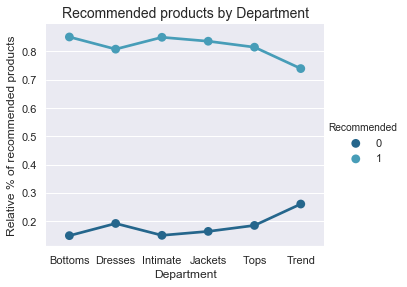

In [33]:
r.reset_index(inplace=True)

g = sns.catplot(x='Department', y='percentage recommended', hue='Recommended',
                capsize=.2, palette="YlGnBu_d", height=4, aspect=1.2,
                kind="point", data=r)
_ = plt.xlabel('Department', size=12)
_ = plt.ylabel('Relative % of recommended products', size=12)
_ = plt.title('Recommended products by Department', size=14)

g.despine(left=True)